<a href="https://colab.research.google.com/github/Rabbia-Ijaz/Face-Recognition-Siamese-Network/blob/main/DMProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting the drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA /machine, this should print a CUDA device:

print(device)

cuda:0


#Extracting Triplets

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
from PIL import Image 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


import torchvision
import torchvision.datasets.folder as tdf
import random

In [ ]:

class DatasetFolder(torchvision.datasets.DatasetFolder):
  def __init__(self, root, transform=None, target_transform=None,
                  loader=tdf.default_loader, is_valid_file=None):
      super(DatasetFolder , self).__init__( root, loader=loader,extensions = IMG_EXTENSIONS ,
                                            transform=transform,
                                            target_transform=target_transform,
                                            is_valid_file=is_valid_file)
      self.imgs = self.samples

  def __getitem__(self,index):
      #print("****************")
      _idx = random.choice(range(1,len(self.imgs)-1))
      path,label=self.imgs[_idx]
      pos_idx=_idx+1
      while(self.imgs[_idx][1]!=self.imgs[pos_idx][1]):
        if(self.imgs[_idx+1][1]==label):
          pos_idx=_idx+1
        elif(self.imgs[_idx-1][1]==label):
          pos_idx=_idx-1
        _idx = random.choice(range(1,len(self.imgs)-1))

      id2=random.choice(range(1,len(self.imgs)-1))

      while(self.imgs[id2][1] == self.imgs[pos_idx][1]):
        id2=random.choice(range(1,len(self.imgs)-1))
      neg_idx=id2

      path_anc=self.imgs[_idx][0]
      path_pos=self.imgs[pos_idx][0]
      path_neg=self.imgs[neg_idx][0]

      #print(path_anc,path_pos)

      labels=torch.tensor([self.imgs[_idx][1],self.imgs[pos_idx][1],self.imgs[neg_idx][1]])
      _img1 = self.loader(path_anc)
      _img2= self.loader(path_pos)
      _img3= self.loader(path_neg)

      #print(_img1,_img2,_img3)


      return self.transform(_img1) , self.transform(_img2) , self.transform(_img3) , labels

  def __len__(self):
        return len(self.samples)

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

In [ ]:
import matplotlib.pyplot as plt
#function for pritning images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Showing Triplets


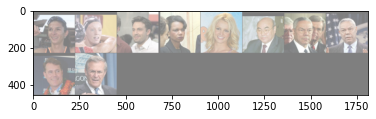

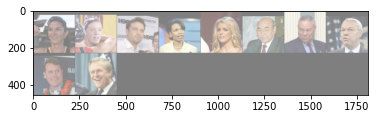

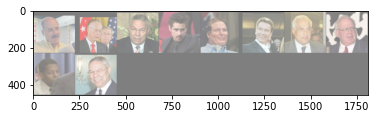

tensor([[ 237,  237,  500],
        [1131, 1131,  926],
        [ 472,  472, 1047],
        [1059, 1059, 1043],
        [ 706,  706,  982],
        [ 411,  411,  385],
        [1047, 1047,  224],
        [1047, 1047,  734],
        [1471, 1471,  876],
        [1414, 1414, 1047]])


In [ ]:

transform = transforms.Compose([
         transforms.Resize((224,224)),
         transforms.ToTensor(),
    ])
Myclass=DatasetFolder("/content/drive/My Drive/lfw",transform)
test_dataloader = DataLoader(Myclass,batch_size=10,shuffle=True)
dataiter = iter(test_dataloader)
image1 ,image2,image3,lables = dataiter.next()
imshow(torchvision.utils.make_grid(image1))
imshow(torchvision.utils.make_grid(image2))
imshow(torchvision.utils.make_grid(image3))
print(lables)

In [ ]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(224*224*8,200),
            nn.ReLU(inplace=True),

            nn.Linear(200, 300),
            nn.ReLU(inplace=True),

            nn.Linear(300, 300)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

# **Loss Function**

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
                        #anc    #pos      #neg
    def forward(self, output1 , output2, output3,  label):
        euc_anc_pos = F.pairwise_distance(output1, output2, keepdim = True)
        euc_anc_neg = F.pairwise_distance(output1, output3, keepdim = True)
        
        #dp=tf.reduce_mean(tf.square(output1-output2))
        #dn=tf.reduce_mean(tf.square(output1-output3))
        #loss_contrastive=tf.max(dp-dn+1,0.0)
        
        #loss_anc_pos = torch.mean((1-label) * torch.pow(euc_anc_pos, 2) +(label) * torch.pow(torch.clamp(self.margin - euc_anc_pos, min=0.0), 2))
        #loss_anc_neg= torch.mean((1-label) * torch.pow(euc_anc_neg, 2) +(label) * torch.pow(torch.clamp(self.margin - euc_anc_neg, min=0.0), 2))
        ans=euc_anc_pos-euc_anc_neg
        mask=(ans>0)+0
        loss=torch.mean(ans*mask)
        #print(loss.eval())
        #loss_contrastive=tf.math.reduce_max(loss,torch.tensor(0.0))
        #print(loss_contrastive)

        #return max(loss_anc_pos-loss_anc_neg)
        return loss

# **Training**

In [ ]:

transform = transforms.Compose([
         transforms.Resize((224,224)),
         transforms.ToTensor(),
    ])
Myclass=DatasetFolder("/content/drive/My Drive/lfw",transform)
train_dataloader = DataLoader(Myclass,batch_size=10,shuffle=True)
print(len(train_dataloader))

339


In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss().cuda()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,5):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , img2, label = data
        img0, img1 , img2, label = img0.cuda(), img1.cuda() ,img2.cuda(), label.cuda()
        optimizer.zero_grad()
        output1,output2,output3= net(img0,img1,img2)
        loss_contrastive = criterion(output1,output2,output3,label)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item()
        if i % 10 == 0:    
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        # if i %10 == 0 :
        #     print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        #     iteration_number +=10
        #     counter.append(iteration_number)
        #     loss_history.append(loss_contrastive.item())
#show_plot(counter,loss_history)

[1,     1] loss: 0.038
[1,    11] loss: 15.026
[1,    21] loss: 13.293
[1,    31] loss: 12.915
[1,    41] loss: 9.222
[1,    51] loss: 10.136
[1,    61] loss: 11.959
[1,    71] loss: 10.857
[1,    81] loss: 9.448
[1,    91] loss: 9.449
[1,   101] loss: 9.433
[1,   111] loss: 11.203
[1,   121] loss: 9.424
[1,   131] loss: 12.469
[1,   141] loss: 8.140
[1,   151] loss: 9.410
[1,   161] loss: 8.676
[1,   171] loss: 6.900
[1,   181] loss: 6.327
[1,   191] loss: 9.407
[1,   201] loss: 3.746
[1,   211] loss: 11.094
[1,   221] loss: 6.644
[1,   231] loss: 6.933
[1,   241] loss: 7.987
[1,   251] loss: 5.650
[1,   261] loss: 7.377
[1,   271] loss: 7.017
[1,   281] loss: 4.788
[1,   291] loss: 5.500
[1,   301] loss: 5.118
[1,   311] loss: 4.738
[1,   321] loss: 7.289
[1,   331] loss: 4.569
[2,     1] loss: 0.515
[2,    11] loss: 6.212
[2,    21] loss: 5.200
[2,    31] loss: 4.034
[2,    41] loss: 7.375
[2,    51] loss: 5.577
[2,    61] loss: 5.883
[2,    71] loss: 5.645
[2,    81] loss: 4.895
[2

# **Testing**

In [ ]:
transform = transforms.Compose([
         transforms.Resize((224,224)),
         transforms.ToTensor(),
    ])
Myclass=DatasetFolder("/content/drive/My Drive/lfw",transform)
test_dataloader = DataLoader(Myclass,batch_size=1,shuffle=True)
total_triplets=len(test_dataloader)

In [ ]:
count=0
margin=0.05
dataiter = iter(test_dataloader)
for i, data in enumerate(test_dataloader,0):
    img0,img1,img2,label = data
    img0_,img1_,img2_,label_=img0.cuda(),img1.cuda(),img2.cuda(),label.cuda()
    concatenated1 = torch.cat((img0,img1),0)
    concatenated2 = torch.cat((img0,img2),0)
    output1,output2,output3= net(img0_,img1_,img2_)
    #euclidean_distance = F.pairwise_distance(output1, output2)

    euc_anc_pos = torch.mean(F.pairwise_distance(output1, output2))
    euc_anc_neg = torch.mean(F.pairwise_distance(output1, output3))
    #print(euc_anc_neg)
    ans=euc_anc_pos-euc_anc_neg-margin
    #print(ans)
    mask=(ans>0)+0
    ans=torch.mean(ans*mask)
    if(ans==0):
      count+=1
print((count/total_triplets)*100)

79.10756501182034
